In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate

# Load your dataset using pandas
data = pd.read_csv('/content/sample_data/Household electricity dataset.csv')

# Let's assume 'target_column' is what you're trying to predict
Y = data['Value'].values

# Drop the target column and use the rest as features
X = data.drop(['Value','Date','Day'], axis=1).values

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert data to time series format
def convert_to_timeseries(matrix, time_steps):
    data = []
    for i in range(len(matrix) - time_steps):
        data.append(matrix[i:i + time_steps])
    return np.array(data)

time_steps = 10
X_series = convert_to_timeseries(X, time_steps)
Y_series = Y[time_steps:]

# LSTM with Attention
encoder_inputs = Input(shape=(time_steps, X.shape[1]))
encoder = LSTM(100, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(time_steps, 1))
decoder_lstm = LSTM(100, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

attention_layer = Attention()
attention_result = attention_layer([decoder_outputs, encoder_outputs])
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_result])

decoder_dense = Dense(1)
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()
print(Y_series)
# Training the model
# Reshape Y_series to match the expected shape
Y_series = Y_series.reshape(Y_series.shape[0], 1)

model.fit([X_series, Y_series], Y_series, batch_size=64, epochs=10, validation_split=0.2)


FileNotFoundError: ignored

Epoch 1/10
19/19 [==============================] - 1s 47ms/step - loss: 21.3190 - val_loss: 17.8290
Epoch 2/10
19/19 [==============================] - 1s 43ms/step - loss: 18.0889 - val_loss: 16.1911
Epoch 3/10
19/19 [==============================] - 1s 42ms/step - loss: 15.2418 - val_loss: 14.6271
Epoch 4/10
19/19 [==============================] - 1s 48ms/step - loss: 13.1121 - val_loss: 12.7336
Epoch 5/10
19/19 [==============================] - 1s 33ms/step - loss: 11.2884 - val_loss: 11.1420
Epoch 6/10
19/19 [==============================] - 0s 20ms/step - loss: 9.9868 - val_loss: 9.4527
Epoch 7/10
19/19 [==============================] - 0s 21ms/step - loss: 8.8190 - val_loss: 7.7373
Epoch 8/10
19/19 [==============================] - 0s 20ms/step - loss: 7.8412 - val_loss: 6.7220
Epoch 9/10
19/19 [==============================] - 0s 22ms/step - loss: 7.1106 - val_loss: 5.9901
Epoch 10/10
19/19 [==============================] - 0s 25ms/step - loss: 6.4388 - val_loss: 5.2796

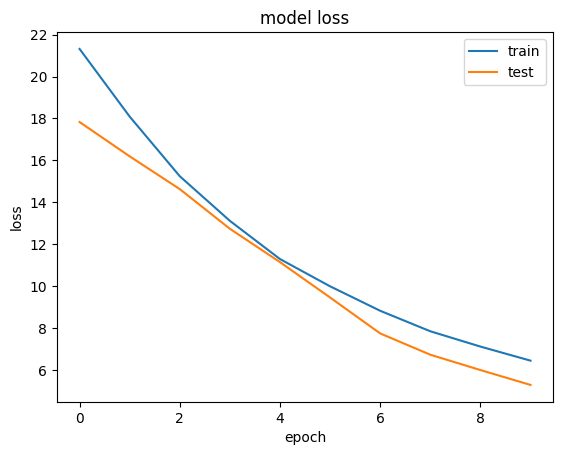

In [ ]:
import matplotlib.pyplot as plt
history = model.fit([X_series, Y_series], Y_series, batch_size=64, epochs=10, validation_split=0.2)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
